#### Import libraries.

In [1]:

import time
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PowerTransformer
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot as plt


#### Show installed GPUs.

In [2]:

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus :
    print("Name: ", gpu.name, " Type: ", gpu.device_type)


Name:  /physical_device:GPU:0  Type:  GPU


#### Load the dataset.

In [3]:

df = pd.read_csv("../dataset/original-noneeg-dataset.csv", sep="|", dtype = {"hr": "float64", "label": "int8"})


#### Display the dataset size.

In [4]:
df.shape

(41992, 2)

#### Build a helper function to convert the set data to the required format to perform the undersampling.

In [5]:

number_of_steps = 30

def build_time_window_structure(df):
    # Splits the dataset into "time windows" to be used as a time series list.
    # The function groups each 30 dataset records (CSV lines) into one record.
    # Each record contains 30 steps and each step contains 1 feature value.
    # Parameters:
    #    df: Dataframe to be splitted.
    # Return:
    #    First list contains all time windows.
    #    Second list contains all target values.
    print("\nStarting build_time_window_structure function.")
    initial_line_number = 0
    first_feat_index = 0
    last_feat_index = 1
    X_array = []
    y_array = []
    while initial_line_number < len(df["label"]):
        target_value = df["label"][initial_line_number]
        sub_matrix = df.iloc[initial_line_number : (initial_line_number + number_of_steps), first_feat_index : last_feat_index]
        sub_matrix_values = sub_matrix.values
        new_line = sub_matrix_values.flatten()
        size_diff = number_of_steps - len(new_line)
        if size_diff > 0:
            last_value = new_line[len(new_line) - 1]
            new_line = np.append(new_line, [last_value] * size_diff)
        X_array.append(new_line)
        y_array.append(target_value)
        initial_line_number += number_of_steps
    print("Quantity of samples (features) => ", len(X_array))
    print("Quantity os samples (labels) => ", len(y_array))
    print("Finishing build_time_window_structure function.")
    return X_array, y_array


#### Perform undersampling to balance the dataset.

In [6]:

# Correct dataset imbalance through undersampling.
print("\nStarting undersampling process.")
X_list, y_list = build_time_window_structure(df)
rus = RandomUnderSampler(random_state = 42)
X_arr = np.array(X_list)
y_arr = np.array(y_list)
X_resampled, y_resampled = rus.fit_resample(X_arr, y_arr)
print("\nQuantity of resampled samples => ", len(y_resampled))



Starting undersampling process.

Starting build_time_window_structure function.
Quantity of samples (features) =>  1400
Quantity os samples (labels) =>  1400
Finishing build_time_window_structure function.

Quantity of resampled samples =>  800


#### Train a Multilayer Perceptron model and evaluate the metrics.
- Layer architecture => Dense (10) + Dense (10) + Dense (10) + Dense (4)
- 800 samples (no data augmentation).

In [7]:

def create_baseline() :
    model = Sequential()
    model.add(Dense(10, input_shape = (30,), activation = 'relu'))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(4, activation = 'softmax'))
    model.summary()
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    return model


# Defining the number of folds (10 k-Fold).
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

pt = PowerTransformer()
pt.fit(X_resampled)
X = pt.transform(X_resampled)
y = y_resampled


# Train the MLP model and evaluate it.
start_time = time.time()
print("\nStarting training at: ", time.strftime("%H:%M:%S", time.localtime()))
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 20)

train_accuracy_by_fold = []
test_accuracy_by_fold = []
fold_number = 1
for train_index, test_index in skf.split(X, y):
    print("Training fold {}".format(fold_number))
    model = create_baseline()
    history = model.fit(X[train_index], y[train_index], validation_split = 0.1,
                            epochs = 300, batch_size = 64, verbose = 1, callbacks = [es])
    _, train_accuracy = model.evaluate(X[train_index], y[train_index], verbose = 0)
    _, test_accuracy = model.evaluate(X[test_index], y[test_index], verbose = 0)
    train_accuracy_by_fold.append(train_accuracy)
    test_accuracy_by_fold.append(test_accuracy)
    fold_number += 1

elapsed_seconds = time.time() - start_time
print("\nTime taken for training: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds)))
print("\n")

# Show metrics.
for i in range(len(train_accuracy_by_fold)):
    print("Fold {} - Train Accuracy {:.4f} - Test Accuracy {:.4f}".format((i + 1),
                            train_accuracy_by_fold[i], test_accuracy_by_fold[i]))
print("\nMean Train Accuracy: {:.4f} ".format(np.mean(train_accuracy_by_fold)))
print("Mean Test Accuracy: {:.4f} ".format(np.mean(test_accuracy_by_fold)))



Starting training at:  08:58:11
Training fold 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                310       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 4)                 44        
                                                                 
Total params: 574
Trainable params: 574
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
11/11 [==============================] - 2s 22ms/step - loss: 1.3767 - accuracy: 0.2809 - val_loss: 1.6703 - val_accuracy: 0.0000

11/11 [==============================] - 0s 4ms/step - loss: 1.2104 - accuracy: 0.4136 - val_loss: 1.4935 - val_accuracy: 0.1250
Epoch 20/300
11/11 [==============================] - 0s 4ms/step - loss: 1.2062 - accuracy: 0.4074 - val_loss: 1.5037 - val_accuracy: 0.1250
Epoch 21/300
11/11 [==============================] - 0s 4ms/step - loss: 1.2020 - accuracy: 0.4105 - val_loss: 1.5208 - val_accuracy: 0.1250
Epoch 00021: early stopping
Training fold 3
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                310       
                                                                 
 dense_9 (Dense)             (None, 10)                110       
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                           

Epoch 20/300
11/11 [==============================] - 0s 5ms/step - loss: 1.1842 - accuracy: 0.4429 - val_loss: 1.5090 - val_accuracy: 0.0000e+00
Epoch 21/300
11/11 [==============================] - 0s 5ms/step - loss: 1.1801 - accuracy: 0.4475 - val_loss: 1.5554 - val_accuracy: 0.0000e+00
Epoch 22/300
11/11 [==============================] - 0s 4ms/step - loss: 1.1780 - accuracy: 0.4475 - val_loss: 1.5875 - val_accuracy: 0.0000e+00
Epoch 23/300
11/11 [==============================] - 0s 4ms/step - loss: 1.1743 - accuracy: 0.4522 - val_loss: 1.5636 - val_accuracy: 0.0000e+00
Epoch 24/300
11/11 [==============================] - 0s 5ms/step - loss: 1.1718 - accuracy: 0.4568 - val_loss: 1.5226 - val_accuracy: 0.0000e+00
Epoch 25/300
11/11 [==============================] - 0s 4ms/step - loss: 1.1711 - accuracy: 0.4599 - val_loss: 1.5395 - val_accuracy: 0.0000e+00
Epoch 26/300
11/11 [==============================] - 0s 4ms/step - loss: 1.1672 - accuracy: 0.4630 - val_loss: 1.5544 - val

Epoch 16/300
11/11 [==============================] - 0s 4ms/step - loss: 1.1692 - accuracy: 0.4645 - val_loss: 1.6089 - val_accuracy: 0.0000e+00
Epoch 17/300
11/11 [==============================] - 0s 4ms/step - loss: 1.1642 - accuracy: 0.4614 - val_loss: 1.6475 - val_accuracy: 0.0000e+00
Epoch 18/300
11/11 [==============================] - 0s 4ms/step - loss: 1.1628 - accuracy: 0.4614 - val_loss: 1.6618 - val_accuracy: 0.0000e+00
Epoch 19/300
11/11 [==============================] - 0s 5ms/step - loss: 1.1642 - accuracy: 0.4599 - val_loss: 1.6649 - val_accuracy: 0.0000e+00
Epoch 20/300
11/11 [==============================] - 0s 4ms/step - loss: 1.1601 - accuracy: 0.4614 - val_loss: 1.5944 - val_accuracy: 0.0000e+00
Epoch 21/300
11/11 [==============================] - 0s 5ms/step - loss: 1.1588 - accuracy: 0.4691 - val_loss: 1.6086 - val_accuracy: 0.0000e+00
Epoch 00021: early stopping
Training fold 7
Model: "sequential_6"
__________________________________________________________

Epoch 17/300
11/11 [==============================] - 0s 5ms/step - loss: 1.2535 - accuracy: 0.3704 - val_loss: 1.4432 - val_accuracy: 0.0000e+00
Epoch 18/300
11/11 [==============================] - 0s 4ms/step - loss: 1.2458 - accuracy: 0.4244 - val_loss: 1.4605 - val_accuracy: 0.0000e+00
Epoch 19/300
11/11 [==============================] - 0s 5ms/step - loss: 1.2372 - accuracy: 0.4444 - val_loss: 1.4943 - val_accuracy: 0.0000e+00
Epoch 20/300
11/11 [==============================] - 0s 4ms/step - loss: 1.2284 - accuracy: 0.4506 - val_loss: 1.4850 - val_accuracy: 0.0000e+00
Epoch 21/300
11/11 [==============================] - 0s 4ms/step - loss: 1.2210 - accuracy: 0.4522 - val_loss: 1.5062 - val_accuracy: 0.0000e+00
Epoch 22/300
11/11 [==============================] - 0s 4ms/step - loss: 1.2129 - accuracy: 0.4522 - val_loss: 1.5559 - val_accuracy: 0.0000e+00
Epoch 23/300
11/11 [==============================] - 0s 4ms/step - loss: 1.2056 - accuracy: 0.4552 - val_loss: 1.5622 - val

11/11 [==============================] - 0s 5ms/step - loss: 1.4095 - accuracy: 0.1975 - val_loss: 1.1705 - val_accuracy: 0.6944
Epoch 3/300
11/11 [==============================] - 0s 4ms/step - loss: 1.3701 - accuracy: 0.2176 - val_loss: 1.2190 - val_accuracy: 0.1667
Epoch 4/300
11/11 [==============================] - 0s 4ms/step - loss: 1.3451 - accuracy: 0.2623 - val_loss: 1.2502 - val_accuracy: 0.1111
Epoch 5/300
11/11 [==============================] - 0s 4ms/step - loss: 1.3322 - accuracy: 0.3549 - val_loss: 1.2771 - val_accuracy: 0.0556
Epoch 6/300
11/11 [==============================] - 0s 4ms/step - loss: 1.3221 - accuracy: 0.4475 - val_loss: 1.3058 - val_accuracy: 0.0278
Epoch 7/300
11/11 [==============================] - 0s 5ms/step - loss: 1.3123 - accuracy: 0.4691 - val_loss: 1.3264 - val_accuracy: 0.0278
Epoch 8/300
11/11 [==============================] - 0s 5ms/step - loss: 1.3022 - accuracy: 0.4676 - val_loss: 1.3437 - val_accuracy: 0.0139
Epoch 9/300
11/11 [======

#### Train a Multilayer Perceptron model and evaluate the metrics.
- Layer architecture => Dense (100) + Dense (200) + Dense (300) + Dense (200) + Dense (100) + Dense (4)
- 800 samples (no data augmentation).

In [8]:

def create_v1() :
    model = Sequential()
    model.add(Dense(100, input_shape = (30,), activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(200, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(300, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(200, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(100, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(4, activation = 'softmax'))
    model.summary()
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    return model


# Defining the number of folds (10 k-Fold).
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

pt = PowerTransformer()
pt.fit(X_resampled)
X = pt.transform(X_resampled)
y = y_resampled


# Train the MLP model and evaluate it.
start_time = time.time()
print("\nStarting training at: ", time.strftime("%H:%M:%S", time.localtime()))
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 20)

train_accuracy_by_fold = []
test_accuracy_by_fold = []
y_predclass_for_report = []
y_testclass_for_report = []
history_by_fold = []
fold_number = 1
for train_index, test_index in skf.split(X, y):
    print("Training fold {}".format(fold_number))
    model = create_v1()
    history = model.fit(X[train_index], y[train_index], validation_split = 0.05,
                            epochs = 300, batch_size = 64, verbose = 1, callbacks = [es])
    _, train_accuracy = model.evaluate(X[train_index], y[train_index], verbose = 0)
    _, test_accuracy = model.evaluate(X[test_index], y[test_index], verbose = 0)
    train_accuracy_by_fold.append(train_accuracy)
    test_accuracy_by_fold.append(test_accuracy)
    y_predclass_for_report.extend(np.argmax(model.predict(X[test_index]), axis = 1))
    y_testclass_for_report.extend(y[test_index])
    history_by_fold.append(history)
    fold_number += 1

elapsed_seconds = time.time() - start_time
print("\nTime taken for training: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds)))
print("\n")

# Show metrics.
for i in range(len(train_accuracy_by_fold)):
    print("Fold {} - Train Accuracy {:.4f} - Test Accuracy {:.4f}".format((i + 1),
                            train_accuracy_by_fold[i], test_accuracy_by_fold[i]))
print("\nMean Train Accuracy: {:.4f} ".format(np.mean(train_accuracy_by_fold)))
print("Mean Test Accuracy: {:.4f} ".format(np.mean(test_accuracy_by_fold)))

print("\nEvaluate other metrics:")
print(classification_report(y_testclass_for_report, y_predclass_for_report, zero_division = 0))



Starting training at:  08:59:05
Training fold 1
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 100)               3100      
                                                                 
 dense_41 (Dense)            (None, 200)               20200     
                                                                 
 dense_42 (Dense)            (None, 300)               60300     
                                                                 
 dense_43 (Dense)            (None, 200)               60200     
                                                                 
 dense_44 (Dense)            (None, 100)               20100     
                                                                 
 dense_45 (Dense)            (None, 4)                 404       
                                                                 
Tota

Epoch 17/300
11/11 [==============================] - 0s 5ms/step - loss: 0.8380 - accuracy: 0.6477 - val_loss: 1.6607 - val_accuracy: 0.1389
Epoch 18/300
11/11 [==============================] - 0s 5ms/step - loss: 0.7837 - accuracy: 0.6784 - val_loss: 1.8303 - val_accuracy: 0.1667
Epoch 19/300
11/11 [==============================] - 0s 5ms/step - loss: 0.7600 - accuracy: 0.6857 - val_loss: 1.6847 - val_accuracy: 0.2500
Epoch 20/300
11/11 [==============================] - 0s 6ms/step - loss: 0.7422 - accuracy: 0.6988 - val_loss: 1.9408 - val_accuracy: 0.0833
Epoch 21/300
11/11 [==============================] - 0s 5ms/step - loss: 0.7376 - accuracy: 0.7061 - val_loss: 2.1692 - val_accuracy: 0.1389
Epoch 00021: early stopping
Training fold 3
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 100)               3100      
                         

Epoch 4/300
11/11 [==============================] - 0s 6ms/step - loss: 1.1454 - accuracy: 0.4605 - val_loss: 1.6168 - val_accuracy: 0.0000e+00
Epoch 5/300
11/11 [==============================] - 0s 7ms/step - loss: 1.1290 - accuracy: 0.4664 - val_loss: 1.3801 - val_accuracy: 0.4167
Epoch 6/300
11/11 [==============================] - 0s 6ms/step - loss: 1.1041 - accuracy: 0.5088 - val_loss: 1.5151 - val_accuracy: 0.0556
Epoch 7/300
11/11 [==============================] - 0s 6ms/step - loss: 1.1016 - accuracy: 0.5029 - val_loss: 1.7063 - val_accuracy: 0.0278
Epoch 8/300
11/11 [==============================] - 0s 6ms/step - loss: 1.0803 - accuracy: 0.5175 - val_loss: 1.5300 - val_accuracy: 0.1111
Epoch 9/300
11/11 [==============================] - 0s 5ms/step - loss: 1.0566 - accuracy: 0.5322 - val_loss: 1.5808 - val_accuracy: 0.3889
Epoch 10/300
11/11 [==============================] - 0s 5ms/step - loss: 1.0561 - accuracy: 0.5249 - val_loss: 1.4281 - val_accuracy: 0.2500
Epoch 11

Training fold 6
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 100)               3100      
                                                                 
 dense_71 (Dense)            (None, 200)               20200     
                                                                 
 dense_72 (Dense)            (None, 300)               60300     
                                                                 
 dense_73 (Dense)            (None, 200)               60200     
                                                                 
 dense_74 (Dense)            (None, 100)               20100     
                                                                 
 dense_75 (Dense)            (None, 4)                 404       
                                                                 
Total params: 164,304
Trainable param

Epoch 15/300
11/11 [==============================] - 0s 5ms/step - loss: 0.8688 - accuracy: 0.6594 - val_loss: 1.6163 - val_accuracy: 0.1389
Epoch 16/300
11/11 [==============================] - 0s 5ms/step - loss: 0.8518 - accuracy: 0.6550 - val_loss: 1.4979 - val_accuracy: 0.4167
Epoch 17/300
11/11 [==============================] - 0s 5ms/step - loss: 0.8414 - accuracy: 0.6594 - val_loss: 1.6913 - val_accuracy: 0.3611
Epoch 18/300
11/11 [==============================] - 0s 5ms/step - loss: 0.7953 - accuracy: 0.6769 - val_loss: 1.6333 - val_accuracy: 0.1944
Epoch 19/300
11/11 [==============================] - 0s 5ms/step - loss: 0.7607 - accuracy: 0.6901 - val_loss: 1.7690 - val_accuracy: 0.1944
Epoch 20/300
11/11 [==============================] - 0s 5ms/step - loss: 0.7362 - accuracy: 0.7032 - val_loss: 1.7371 - val_accuracy: 0.1389
Epoch 21/300
11/11 [==============================] - 0s 5ms/step - loss: 0.7164 - accuracy: 0.7178 - val_loss: 2.4021 - val_accuracy: 0.0833
Epoch 

Epoch 5/300
11/11 [==============================] - 0s 6ms/step - loss: 1.1307 - accuracy: 0.4985 - val_loss: 1.6475 - val_accuracy: 0.0833
Epoch 6/300
11/11 [==============================] - 0s 6ms/step - loss: 1.1133 - accuracy: 0.4927 - val_loss: 1.7020 - val_accuracy: 0.0833
Epoch 7/300
11/11 [==============================] - 0s 6ms/step - loss: 1.0820 - accuracy: 0.5219 - val_loss: 1.4260 - val_accuracy: 0.1667
Epoch 8/300
11/11 [==============================] - 0s 7ms/step - loss: 1.0773 - accuracy: 0.5380 - val_loss: 1.6348 - val_accuracy: 0.0833
Epoch 9/300
11/11 [==============================] - 0s 6ms/step - loss: 1.0559 - accuracy: 0.5351 - val_loss: 1.9427 - val_accuracy: 0.0000e+00
Epoch 10/300
11/11 [==============================] - 0s 6ms/step - loss: 1.0386 - accuracy: 0.5336 - val_loss: 1.6122 - val_accuracy: 0.1111
Epoch 11/300
11/11 [==============================] - 0s 6ms/step - loss: 1.0143 - accuracy: 0.5731 - val_loss: 1.4991 - val_accuracy: 0.2778
Epoch 1

#### Train a Multilayer Perceptron model and evaluate the metrics.
- Layer architecture => Dense (100) + Dense (200) + Dense (300) + Dense (200) + Dense (100) + Dense (4)
- 4000 samples - Data augmentation (5x).

In [9]:

def create_v2() :
    model = Sequential()
    model.add(Dense(100, input_shape = (30,), activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(200, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(300, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(200, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(100, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(4, activation = 'softmax'))
    model.summary()
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    return model


# Defining the number of folds (10 k-Fold).
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

# Data augmentation (5x).
print("\nStarting data augmentation.")
X_all_oversampled = []
y_all_oversampled = []
X_resampled_values = X_resampled
for count in range(0, 4):
    X_oversampled, y_oversampled = resample(X_resampled_values[y_resampled == count],
                                            y_resampled[y_resampled == count],
                                            replace = True,
                                            n_samples = 1000,
                                            random_state = 42)
    X_all_oversampled.extend(X_oversampled)
    y_all_oversampled.extend(y_oversampled)
X_resampled_arr = np.array(X_all_oversampled)
y_resampled_arr = np.array(y_all_oversampled)
print("\nQuantity of samples generated by oversampling => ", len(y_resampled_arr))

# Normalize data using box-cox method.
pt = PowerTransformer()
pt.fit(X_resampled_arr)
X = pt.transform(X_resampled_arr)
y = y_resampled_arr

# Defining the number of folds (10 k-Fold).
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)


# Train the MLP model and evaluate it.
start_time = time.time()
print("\nStarting training at: ", time.strftime("%H:%M:%S", time.localtime()))
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 30)

train_accuracy_by_fold = []
test_accuracy_by_fold = []
y_predclass_for_report = []
y_testclass_for_report = []
history_by_fold = []
fold_number = 1
for train_index, test_index in skf.split(X, y):
    print("Training fold {}".format(fold_number))
    model = create_v2()
    history = model.fit(X[train_index], y[train_index], validation_split = 0.1,
                            epochs = 300, batch_size = 64, verbose = 1, callbacks = [es])
    _, train_accuracy = model.evaluate(X[train_index], y[train_index], verbose = 0)
    _, test_accuracy = model.evaluate(X[test_index], y[test_index], verbose = 0)
    train_accuracy_by_fold.append(train_accuracy)
    test_accuracy_by_fold.append(test_accuracy)
    y_predclass_for_report.extend(np.argmax(model.predict(X[test_index]), axis = 1))
    y_testclass_for_report.extend(y[test_index])
    history_by_fold.append(history)
    fold_number += 1

elapsed_seconds = time.time() - start_time
print("\nTime taken for training: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds)))
print("\n")

# Show metrics.
for i in range(len(train_accuracy_by_fold)):
    print("Fold {} - Train Accuracy {:.4f} - Test Accuracy {:.4f}".format((i + 1),
                            train_accuracy_by_fold[i], test_accuracy_by_fold[i]))
print("\nMean Train Accuracy: {:.4f} ".format(np.mean(train_accuracy_by_fold)))
print("Mean Test Accuracy: {:.4f} ".format(np.mean(test_accuracy_by_fold)))

print("\nEvaluate other metrics:")
print(classification_report(y_testclass_for_report, y_predclass_for_report, zero_division = 0))



Starting data augmentation.

Quantity of samples generated by oversampling =>  4000

Starting training at:  09:00:10
Training fold 1
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 100)               3100      
                                                                 
 dense_101 (Dense)           (None, 200)               20200     
                                                                 
 dense_102 (Dense)           (None, 300)               60300     
                                                                 
 dense_103 (Dense)           (None, 200)               60200     
                                                                 
 dense_104 (Dense)           (None, 100)               20100     
                                                                 
 dense_105 (Dense)           (None, 4)             

51/51 [==============================] - 0s 3ms/step - loss: 0.0693 - accuracy: 0.9756 - val_loss: 0.5793 - val_accuracy: 0.8417
Epoch 50/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0679 - accuracy: 0.9769 - val_loss: 0.4825 - val_accuracy: 0.9056
Epoch 51/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0651 - accuracy: 0.9765 - val_loss: 0.5576 - val_accuracy: 0.8917
Epoch 52/300
51/51 [==============================] - 0s 4ms/step - loss: 0.0677 - accuracy: 0.9759 - val_loss: 0.4230 - val_accuracy: 0.9222
Epoch 53/300
51/51 [==============================] - 0s 4ms/step - loss: 0.0752 - accuracy: 0.9719 - val_loss: 0.5304 - val_accuracy: 0.9056
Epoch 54/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0757 - accuracy: 0.9698 - val_loss: 0.5586 - val_accuracy: 0.9028
Epoch 55/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0769 - accuracy: 0.9716 - val_loss: 0.7104 - val_accuracy: 0.8167
Epoch 56/300
51/51 

Epoch 16/300
51/51 [==============================] - 0s 4ms/step - loss: 0.2819 - accuracy: 0.8917 - val_loss: 0.8707 - val_accuracy: 0.6667
Epoch 17/300
51/51 [==============================] - 0s 3ms/step - loss: 0.2672 - accuracy: 0.8963 - val_loss: 0.8282 - val_accuracy: 0.6611
Epoch 18/300
51/51 [==============================] - 0s 3ms/step - loss: 0.2501 - accuracy: 0.9062 - val_loss: 0.7494 - val_accuracy: 0.7194
Epoch 19/300
51/51 [==============================] - 0s 3ms/step - loss: 0.2583 - accuracy: 0.9000 - val_loss: 0.9027 - val_accuracy: 0.6639
Epoch 20/300
51/51 [==============================] - 0s 3ms/step - loss: 0.2370 - accuracy: 0.9120 - val_loss: 0.8473 - val_accuracy: 0.6778
Epoch 21/300
51/51 [==============================] - 0s 4ms/step - loss: 0.2212 - accuracy: 0.9167 - val_loss: 0.5242 - val_accuracy: 0.8306
Epoch 22/300
51/51 [==============================] - 0s 4ms/step - loss: 0.2325 - accuracy: 0.9136 - val_loss: 0.7381 - val_accuracy: 0.7000
Epoch 

51/51 [==============================] - 1s 8ms/step - loss: 1.2204 - accuracy: 0.4441 - val_loss: 1.4539 - val_accuracy: 0.0389
Epoch 2/300
51/51 [==============================] - 0s 5ms/step - loss: 1.0728 - accuracy: 0.5478 - val_loss: 1.2680 - val_accuracy: 0.3444
Epoch 3/300
51/51 [==============================] - 0s 3ms/step - loss: 0.9886 - accuracy: 0.5861 - val_loss: 1.5097 - val_accuracy: 0.0861
Epoch 4/300
51/51 [==============================] - 0s 3ms/step - loss: 0.9025 - accuracy: 0.6185 - val_loss: 1.5275 - val_accuracy: 0.1000
Epoch 5/300
51/51 [==============================] - 0s 3ms/step - loss: 0.8060 - accuracy: 0.6660 - val_loss: 1.3789 - val_accuracy: 0.1472
Epoch 6/300
51/51 [==============================] - 0s 4ms/step - loss: 0.7215 - accuracy: 0.7034 - val_loss: 1.1441 - val_accuracy: 0.3194
Epoch 7/300
51/51 [==============================] - 0s 4ms/step - loss: 0.6554 - accuracy: 0.7352 - val_loss: 0.8639 - val_accuracy: 0.7222
Epoch 8/300
51/51 [======

Epoch 59/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0590 - accuracy: 0.9781 - val_loss: 0.6534 - val_accuracy: 0.9250
Epoch 60/300
51/51 [==============================] - 0s 4ms/step - loss: 0.0802 - accuracy: 0.9694 - val_loss: 1.0069 - val_accuracy: 0.8000
Epoch 61/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0587 - accuracy: 0.9784 - val_loss: 0.6255 - val_accuracy: 0.9222
Epoch 62/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0638 - accuracy: 0.9741 - val_loss: 0.7179 - val_accuracy: 0.8639
Epoch 63/300
51/51 [==============================] - 0s 4ms/step - loss: 0.0839 - accuracy: 0.9701 - val_loss: 0.5384 - val_accuracy: 0.9028
Epoch 64/300
51/51 [==============================] - 0s 4ms/step - loss: 0.1056 - accuracy: 0.9623 - val_loss: 0.6788 - val_accuracy: 0.8556
Epoch 65/300
51/51 [==============================] - 0s 5ms/step - loss: 0.1936 - accuracy: 0.9361 - val_loss: 0.7754 - val_accuracy: 0.8694
Epoch 

Epoch 40/300
51/51 [==============================] - 0s 4ms/step - loss: 0.0653 - accuracy: 0.9756 - val_loss: 0.6984 - val_accuracy: 0.8750
Epoch 41/300
51/51 [==============================] - 0s 4ms/step - loss: 0.0863 - accuracy: 0.9682 - val_loss: 0.7206 - val_accuracy: 0.8444
Epoch 42/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0736 - accuracy: 0.9719 - val_loss: 0.7194 - val_accuracy: 0.8889
Epoch 43/300
51/51 [==============================] - 0s 5ms/step - loss: 0.1010 - accuracy: 0.9608 - val_loss: 0.7770 - val_accuracy: 0.8250
Epoch 44/300
51/51 [==============================] - 0s 5ms/step - loss: 0.1757 - accuracy: 0.9420 - val_loss: 0.5747 - val_accuracy: 0.8583
Epoch 45/300
51/51 [==============================] - 0s 6ms/step - loss: 0.1604 - accuracy: 0.9358 - val_loss: 0.5719 - val_accuracy: 0.8583
Epoch 46/300
51/51 [==============================] - 0s 6ms/step - loss: 0.0878 - accuracy: 0.9676 - val_loss: 0.5877 - val_accuracy: 0.8694
Epoch 

Epoch 23/300
51/51 [==============================] - 0s 5ms/step - loss: 0.2630 - accuracy: 0.8981 - val_loss: 0.7711 - val_accuracy: 0.6833
Epoch 24/300
51/51 [==============================] - 0s 5ms/step - loss: 0.1854 - accuracy: 0.9250 - val_loss: 0.4609 - val_accuracy: 0.8806
Epoch 25/300
51/51 [==============================] - 0s 5ms/step - loss: 0.1653 - accuracy: 0.9346 - val_loss: 0.5946 - val_accuracy: 0.7556
Epoch 26/300
51/51 [==============================] - 0s 4ms/step - loss: 0.1547 - accuracy: 0.9429 - val_loss: 0.6907 - val_accuracy: 0.7694
Epoch 27/300
51/51 [==============================] - 0s 4ms/step - loss: 0.1802 - accuracy: 0.9284 - val_loss: 0.5756 - val_accuracy: 0.7639
Epoch 28/300
51/51 [==============================] - 0s 5ms/step - loss: 0.1586 - accuracy: 0.9414 - val_loss: 0.3719 - val_accuracy: 0.9167
Epoch 29/300
51/51 [==============================] - 0s 4ms/step - loss: 0.1401 - accuracy: 0.9509 - val_loss: 0.7842 - val_accuracy: 0.7278
Epoch 

Epoch 81/300
51/51 [==============================] - 0s 8ms/step - loss: 0.0624 - accuracy: 0.9772 - val_loss: 0.5054 - val_accuracy: 0.8333
Epoch 82/300
51/51 [==============================] - 0s 7ms/step - loss: 0.0342 - accuracy: 0.9898 - val_loss: 0.3458 - val_accuracy: 0.9389
Epoch 83/300
51/51 [==============================] - 0s 7ms/step - loss: 0.0273 - accuracy: 0.9910 - val_loss: 0.4681 - val_accuracy: 0.8917
Epoch 84/300
51/51 [==============================] - 0s 6ms/step - loss: 0.0218 - accuracy: 0.9941 - val_loss: 0.3310 - val_accuracy: 0.9500
Epoch 85/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0240 - accuracy: 0.9910 - val_loss: 0.3802 - val_accuracy: 0.9222
Epoch 86/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0298 - accuracy: 0.9892 - val_loss: 0.3183 - val_accuracy: 0.9583
Epoch 87/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0563 - accuracy: 0.9815 - val_loss: 0.4916 - val_accuracy: 0.8833
Epoch 

Epoch 14/300
51/51 [==============================] - 0s 6ms/step - loss: 0.3266 - accuracy: 0.8685 - val_loss: 0.7023 - val_accuracy: 0.7083
Epoch 15/300
51/51 [==============================] - 0s 5ms/step - loss: 0.3072 - accuracy: 0.8818 - val_loss: 0.6893 - val_accuracy: 0.6444
Epoch 16/300
51/51 [==============================] - 0s 5ms/step - loss: 0.3147 - accuracy: 0.8772 - val_loss: 0.5179 - val_accuracy: 0.8750
Epoch 17/300
51/51 [==============================] - 0s 4ms/step - loss: 0.2831 - accuracy: 0.8917 - val_loss: 0.7381 - val_accuracy: 0.6722
Epoch 18/300
51/51 [==============================] - 0s 4ms/step - loss: 0.3257 - accuracy: 0.8846 - val_loss: 0.8372 - val_accuracy: 0.6556
Epoch 19/300
51/51 [==============================] - 0s 5ms/step - loss: 0.3014 - accuracy: 0.8840 - val_loss: 0.7018 - val_accuracy: 0.7500
Epoch 20/300
51/51 [==============================] - 0s 5ms/step - loss: 0.2310 - accuracy: 0.9191 - val_loss: 0.5048 - val_accuracy: 0.7944
Epoch 

Epoch 72/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0358 - accuracy: 0.9858 - val_loss: 0.3864 - val_accuracy: 0.9333
Epoch 73/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0395 - accuracy: 0.9846 - val_loss: 0.3955 - val_accuracy: 0.8944
Epoch 00073: early stopping
Training fold 7
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136 (Dense)           (None, 100)               3100      
                                                                 
 dense_137 (Dense)           (None, 200)               20200     
                                                                 
 dense_138 (Dense)           (None, 300)               60300     
                                                                 
 dense_139 (Dense)           (None, 200)               60200     
                                                       

Epoch 48/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0819 - accuracy: 0.9704 - val_loss: 0.7585 - val_accuracy: 0.7972
Epoch 49/300
51/51 [==============================] - 0s 6ms/step - loss: 0.0739 - accuracy: 0.9722 - val_loss: 0.6781 - val_accuracy: 0.8278
Epoch 50/300
51/51 [==============================] - 0s 6ms/step - loss: 0.0901 - accuracy: 0.9648 - val_loss: 0.8575 - val_accuracy: 0.8028
Epoch 51/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0739 - accuracy: 0.9704 - val_loss: 0.7594 - val_accuracy: 0.8306
Epoch 52/300
51/51 [==============================] - 0s 5ms/step - loss: 0.1484 - accuracy: 0.9531 - val_loss: 0.6466 - val_accuracy: 0.8194
Epoch 53/300
51/51 [==============================] - 0s 5ms/step - loss: 0.1911 - accuracy: 0.9336 - val_loss: 1.0853 - val_accuracy: 0.7583
Epoch 54/300
51/51 [==============================] - 0s 4ms/step - loss: 0.1276 - accuracy: 0.9531 - val_loss: 0.6546 - val_accuracy: 0.7917
Epoch 

51/51 [==============================] - 1s 7ms/step - loss: 1.1881 - accuracy: 0.4694 - val_loss: 1.7145 - val_accuracy: 0.0306
Epoch 2/300
51/51 [==============================] - 0s 5ms/step - loss: 1.0590 - accuracy: 0.5528 - val_loss: 1.7511 - val_accuracy: 0.0194
Epoch 3/300
51/51 [==============================] - 0s 3ms/step - loss: 0.9868 - accuracy: 0.5759 - val_loss: 1.3268 - val_accuracy: 0.1389
Epoch 4/300
51/51 [==============================] - 0s 3ms/step - loss: 0.8796 - accuracy: 0.6327 - val_loss: 1.1077 - val_accuracy: 0.4111
Epoch 5/300
51/51 [==============================] - 0s 4ms/step - loss: 0.7867 - accuracy: 0.6812 - val_loss: 1.3220 - val_accuracy: 0.2222
Epoch 6/300
51/51 [==============================] - 0s 4ms/step - loss: 0.7211 - accuracy: 0.7062 - val_loss: 1.3807 - val_accuracy: 0.2778
Epoch 7/300
51/51 [==============================] - 0s 4ms/step - loss: 0.6347 - accuracy: 0.7432 - val_loss: 1.0033 - val_accuracy: 0.4111
Epoch 8/300
51/51 [======

Epoch 59/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0743 - accuracy: 0.9719 - val_loss: 0.3768 - val_accuracy: 0.9028
Epoch 60/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0552 - accuracy: 0.9793 - val_loss: 0.5070 - val_accuracy: 0.8583
Epoch 61/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0432 - accuracy: 0.9843 - val_loss: 0.3903 - val_accuracy: 0.9139
Epoch 62/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0345 - accuracy: 0.9880 - val_loss: 0.3641 - val_accuracy: 0.9028
Epoch 63/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0566 - accuracy: 0.9821 - val_loss: 0.4783 - val_accuracy: 0.8750
Epoch 64/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0545 - accuracy: 0.9809 - val_loss: 0.3958 - val_accuracy: 0.9417
Epoch 65/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0597 - accuracy: 0.9796 - val_loss: 0.4728 - val_accuracy: 0.8806
Epoch 

Epoch 7/300
51/51 [==============================] - 0s 5ms/step - loss: 0.6435 - accuracy: 0.7432 - val_loss: 1.3398 - val_accuracy: 0.3194
Epoch 8/300
51/51 [==============================] - 0s 5ms/step - loss: 0.5717 - accuracy: 0.7642 - val_loss: 1.1715 - val_accuracy: 0.3944
Epoch 9/300
51/51 [==============================] - 0s 5ms/step - loss: 0.5249 - accuracy: 0.7910 - val_loss: 0.9850 - val_accuracy: 0.4417
Epoch 10/300
51/51 [==============================] - 0s 5ms/step - loss: 0.5135 - accuracy: 0.7941 - val_loss: 0.8333 - val_accuracy: 0.5833
Epoch 11/300
51/51 [==============================] - 0s 6ms/step - loss: 0.4594 - accuracy: 0.8136 - val_loss: 0.9013 - val_accuracy: 0.5222
Epoch 12/300
51/51 [==============================] - 0s 5ms/step - loss: 0.4456 - accuracy: 0.8253 - val_loss: 1.2955 - val_accuracy: 0.4944
Epoch 13/300
51/51 [==============================] - 0s 5ms/step - loss: 0.4327 - accuracy: 0.8324 - val_loss: 0.7451 - val_accuracy: 0.6389
Epoch 14/

Epoch 65/300
51/51 [==============================] - 0s 5ms/step - loss: 0.1705 - accuracy: 0.9398 - val_loss: 0.5410 - val_accuracy: 0.8472
Epoch 66/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0752 - accuracy: 0.9719 - val_loss: 0.4740 - val_accuracy: 0.8972
Epoch 00066: early stopping
Training fold 10
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_154 (Dense)           (None, 100)               3100      
                                                                 
 dense_155 (Dense)           (None, 200)               20200     
                                                                 
 dense_156 (Dense)           (None, 300)               60300     
                                                                 
 dense_157 (Dense)           (None, 200)               60200     
                                                      

Epoch 48/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0763 - accuracy: 0.9691 - val_loss: 0.5009 - val_accuracy: 0.8250
Epoch 49/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0705 - accuracy: 0.9753 - val_loss: 0.5245 - val_accuracy: 0.8083
Epoch 50/300
51/51 [==============================] - 0s 6ms/step - loss: 0.0602 - accuracy: 0.9781 - val_loss: 0.2954 - val_accuracy: 0.9139
Epoch 51/300
51/51 [==============================] - 0s 6ms/step - loss: 0.0525 - accuracy: 0.9806 - val_loss: 0.3086 - val_accuracy: 0.9139
Epoch 52/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0479 - accuracy: 0.9840 - val_loss: 0.3351 - val_accuracy: 0.9139
Epoch 53/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0486 - accuracy: 0.9815 - val_loss: 0.2920 - val_accuracy: 0.9139
Epoch 54/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0581 - accuracy: 0.9787 - val_loss: 0.4319 - val_accuracy: 0.9028
Epoch 

51/51 [==============================] - 0s 4ms/step - loss: 0.0402 - accuracy: 0.9858 - val_loss: 0.2748 - val_accuracy: 0.9167
Epoch 106/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0254 - accuracy: 0.9920 - val_loss: 0.2076 - val_accuracy: 0.9639
Epoch 107/300
51/51 [==============================] - 0s 4ms/step - loss: 0.0185 - accuracy: 0.9935 - val_loss: 0.2405 - val_accuracy: 0.9694
Epoch 108/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0277 - accuracy: 0.9901 - val_loss: 0.2936 - val_accuracy: 0.9417
Epoch 109/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0333 - accuracy: 0.9877 - val_loss: 0.3334 - val_accuracy: 0.9222
Epoch 110/300
51/51 [==============================] - 0s 6ms/step - loss: 0.0389 - accuracy: 0.9861 - val_loss: 0.3978 - val_accuracy: 0.9361
Epoch 111/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0465 - accuracy: 0.9852 - val_loss: 0.5086 - val_accuracy: 0.8667
Epoch 112/300

#### Show loss history by epochs.

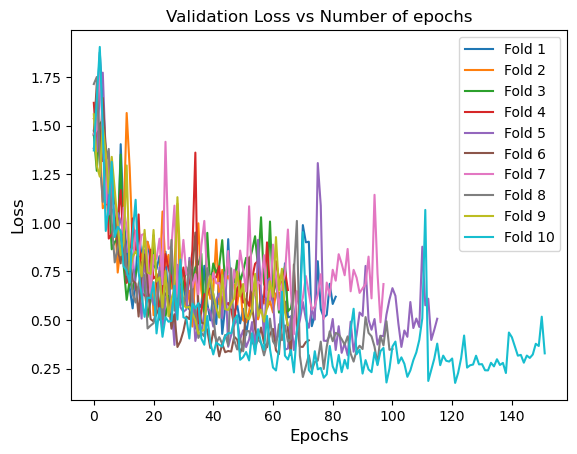

In [10]:

# Plot loss history
for i in range(len(history_by_fold)):
    plt.plot(history_by_fold[i].history["val_loss"], label = "Fold {}".format(i + 1))
plt.title("Validation Loss vs Number of epochs", fontsize = 12)
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend()
plt.show()


#### Show accuracy history by epochs.

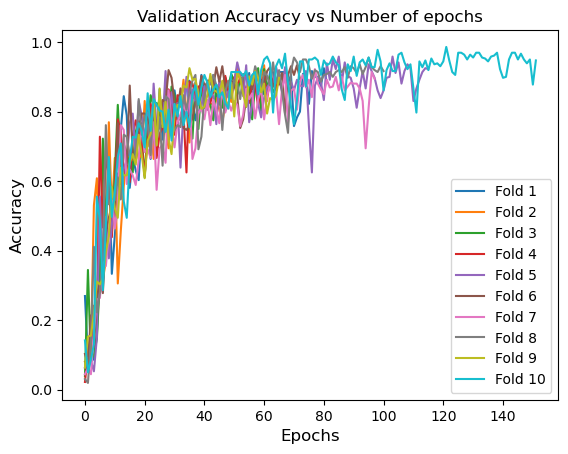

In [11]:

# Plot accuracy history
for i in range(len(history_by_fold)):
    plt.plot(history_by_fold[i].history["val_accuracy"], label = "Fold {}".format(i + 1))
plt.title("Validation Accuracy vs Number of epochs", fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.legend()
plt.show()
